In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py

tf.get_logger().setLevel('ERROR')
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.73.57.171)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by Farmers Telephone Cooperative, Inc. (Sumter, SC) [122.65 km]: 27.297 ms
Testing download speed................................................................................
Download: 1322.19 Mbit/s
Testing upload speed......................................................................................................
Upload: 455.75 Mbit/s


# Import dataset

In [ ]:
from google.colab import drive
import os

drive.mount('/content/GoogleDrive', force_remount=True)
path = '/content/GoogleDrive/My Drive/Vietnamese Foods'
os.chdir(path)
!ls

In [4]:
# Move dataset to /tmp cause reading files from Drive is very slow
!cp Dataset/vietnamese-foods-split.zip /tmp
!unzip -q /tmp/vietnamese-foods-split.zip -d /tmp

# Check GPU working

In [5]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)

Found GPU at: /device:GPU:0


# Setup path

In [7]:
TRAIN_PATH = '/tmp/Images/Train'
VALIDATE_PATH = '/tmp/Images/Validate'
TEST_PATH = '/tmp/Images/Test'

In [8]:
PATH = 'Models/VGG19'

BASE_MODEL_BEST = os.path.join(PATH, 'base_model_best.hdf5')
BASE_MODEL_TRAINED = os.path.join(PATH, 'base_model_trained.hdf5')
BASE_MODEL_FIG = os.path.join(PATH, 'base_model_fig.jpg')

FINE_TUNE_MODEL_BEST = os.path.join(PATH, 'fine_tune_model_best.hdf5')
FINE_TUNE_MODEL_TRAINED = os.path.join(PATH, 'fine_tune_model_trained.hdf5')
FINE_TUNE_MODE_FIG = os.path.join(PATH, 'fine_tune_model_fig.jpg')

# Preparing data

In [9]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 128

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
validate_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

In [11]:
generated_train_data = train_generator.flow_from_directory(TRAIN_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_validate_data = validate_generator.flow_from_directory(VALIDATE_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_test_data = test_generator.flow_from_directory(TEST_PATH, target_size=IMAGE_SIZE)

Found 17581 images belonging to 30 classes.
Found 2515 images belonging to 30 classes.
Found 5040 images belonging to 30 classes.


# Model implement

In [12]:
CLASSES = 30
INITIAL_EPOCHS = 15
FINE_TUNE_EPOCHS = 15
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
FINE_TUNE_AT = 12

## Define the model

In [13]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [14]:
pretrained_model = VGG19(weights='imagenet', include_top=False)
last_output = pretrained_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

80142336/80134624 [==============================] - 0s 0us/step


## Callbacks

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
base_checkpointer = ModelCheckpoint(
    filepath = BASE_MODEL_BEST, 
    save_best_only = True, 
    verbose = 1
)

fine_tune_checkpointer = ModelCheckpoint(
    filepath = FINE_TUNE_MODEL_BEST, 
    save_best_only = True,
    verbose = 1, 
)

# Stop if no improvement after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

## Stage 1: Transfer learning

In [16]:
for layer in pretrained_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    callbacks = [base_checkpointer, early_stopping],
    epochs = INITIAL_EPOCHS,
    verbose = 1,
)
model.save(BASE_MODEL_TRAINED)

Epoch 1/15
104/137 [=====================>........] - ETA: 2:14 - loss: 3.0162 - accuracy: 0.1588

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


137/137 [==============================] - 631s 4s/step - loss: 2.9403 - accuracy: 0.1749 - val_loss: 2.5859 - val_accuracy: 0.2521

Epoch 00001: val_loss improved from inf to 2.58585, saving model to Models/VGG19/base_model_best.hdf5
Epoch 2/15
137/137 [==============================] - 601s 4s/step - loss: 2.5039 - accuracy: 0.2745 - val_loss: 2.2945 - val_accuracy: 0.3466

Epoch 00002: val_loss improved from 2.58585 to 2.29447, saving model to Models/VGG19/base_model_best.hdf5
Epoch 3/15
137/137 [==============================] - 601s 4s/step - loss: 2.3210 - accuracy: 0.3271 - val_loss: 2.1312 - val_accuracy: 0.3791

Epoch 00003: val_loss improved from 2.29447 to 2.13125, saving model to Models/VGG19/base_model_best.hdf5
Epoch 4/15
137/137 [==============================] - 605s 4s/step - loss: 2.2105 - accuracy: 0.3551 - val_loss: 1.9939 - val_accuracy: 0.4215

Epoch 00004: val_loss improved from 2.13125 to 1.99385, saving model to Models/VGG19/base_model_best.hdf5
Epoch 5/15
137/

In [28]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

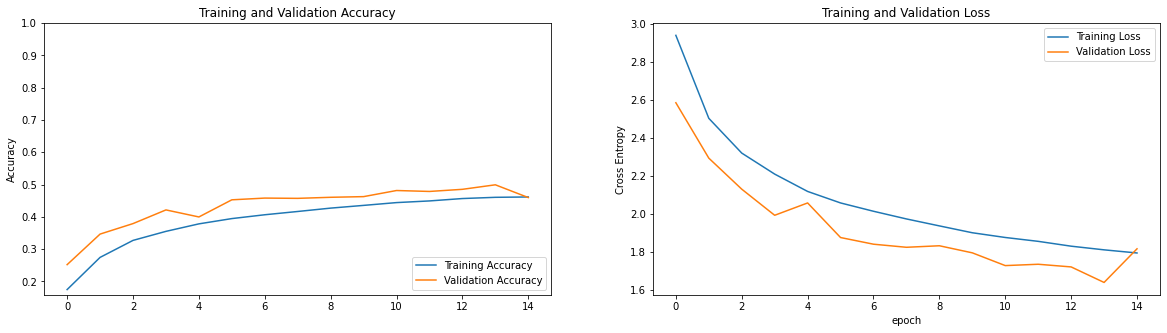

In [29]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(BASE_MODEL_FIG)
plt.show()

## Stage 2: Fine tuning

In [20]:
for layer in pretrained_model.layers[:FINE_TUNE_AT]: layer.trainable = False
for layer in pretrained_model.layers[FINE_TUNE_AT:]: layer.trainable = True

In [21]:
from tensorflow.keras.optimizers import SGD
model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [22]:
history_fine = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    initial_epoch = history.epoch[-1],
    callbacks = [fine_tune_checkpointer, early_stopping],
    verbose = 1,
)
model.save(FINE_TUNE_MODEL_TRAINED)

Epoch 15/30
110/137 [=======================>......] - ETA: 1:49 - loss: 1.6263 - accuracy: 0.5159

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


137/137 [==============================] - 598s 4s/step - loss: 1.6048 - accuracy: 0.5216 - val_loss: 1.5318 - val_accuracy: 0.5382

Epoch 00015: val_loss improved from inf to 1.53176, saving model to Models/VGG19/fine_tune_model_best.hdf5
Epoch 16/30
137/137 [==============================] - 594s 4s/step - loss: 1.4469 - accuracy: 0.5638 - val_loss: 1.3722 - val_accuracy: 0.5785

Epoch 00016: val_loss improved from 1.53176 to 1.37217, saving model to Models/VGG19/fine_tune_model_best.hdf5
Epoch 17/30
137/137 [==============================] - 598s 4s/step - loss: 1.3610 - accuracy: 0.5882 - val_loss: 1.3106 - val_accuracy: 0.6086

Epoch 00017: val_loss improved from 1.37217 to 1.31056, saving model to Models/VGG19/fine_tune_model_best.hdf5
Epoch 18/30
137/137 [==============================] - 587s 4s/step - loss: 1.2838 - accuracy: 0.6122 - val_loss: 1.2666 - val_accuracy: 0.6242

Epoch 00018: val_loss improved from 1.31056 to 1.26661, saving model to Models/VGG19/fine_tune_model_be

In [30]:
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']
val_acc += history_fine.history['val_accuracy']
val_loss += history_fine.history['val_loss']

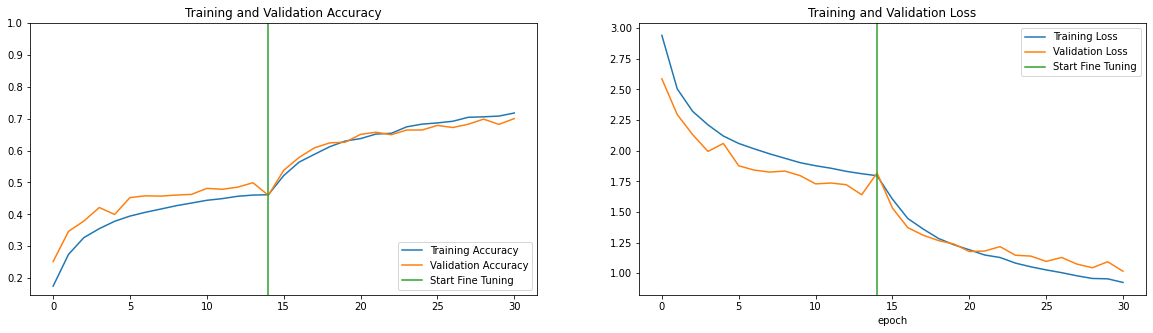

In [31]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([INITIAL_EPOCHS - 1, INITIAL_EPOCHS - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.plot([INITIAL_EPOCHS - 1, INITIAL_EPOCHS - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(FINE_TUNE_MODE_FIG)
plt.show()

# Evaluation

In [32]:
loss, accuracy = model.evaluate(generated_test_data)
print('Test accuracy:', accuracy)

158/158 [==============================] - 90s 543ms/step - loss: 1.0144 - accuracy: 0.7048
Test accuracy: 0.7047619223594666


In [ ]:
import gc
del model
gc.collect()